In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

from utils import *

/home/wanhr/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
local_ip = "10.215.173.1"
dl_pkts = np.zeros([0, 3])
ul_pkts = np.zeros([0, 3])

for i in [1]:
  filename = "~/Documents/data/cos513/5G_Traffic_Datasets/Game_Streaming/GeForce_Now/GeForce_Now_{}.csv".format(i)

  df = load_csv(filename)
  # stats_src_ip(df)
  # stats_dst_ip(df)
  dl_data = extract_dl_pkt_interval_time(df, local_ip)
  ul_data = extract_ul_pkt_interval_time(df, local_ip)
  dl_pkts = np.concatenate((dl_pkts, dl_data), axis=0)
  ul_pkts = np.concatenate((ul_pkts, ul_data), axis=0)
  print(dl_pkts.shape)
  print(ul_pkts.shape)
  # dl_pkts = extract_dl_pkt_interval_time(df, local_ip)
  # ul_pkts = extract_ul_pkt_interval_time(df, local_ip)

(3430592, 3)
(526743, 3)


In [3]:
FONT_SIZE = 35
plt.rcParams["font.size"] = FONT_SIZE


In [4]:
dl_pkt_interval = dl_pkts[dl_pkts[:, 0] < 0.05, :]
ul_pkt_interval = ul_pkts[ul_pkts[:, 0] < 0.05, :]

dl_pkt_interval[:, 0] = dl_pkt_interval[:, 0] * 1000
ul_pkt_interval[:, 0] = ul_pkt_interval[:, 0] * 1000

dl_count, dl_bins_count = np.histogram(dl_pkt_interval[:, 0], bins=1000) 
dl_pdf = dl_count / sum(dl_count) 
dl_cdf = np.cumsum(dl_pdf) 

ul_count, ul_bins_count = np.histogram(ul_pkt_interval[:, 0], bins=1000) 
ul_pdf = ul_count / sum(ul_count) 
ul_cdf = np.cumsum(ul_pdf) 

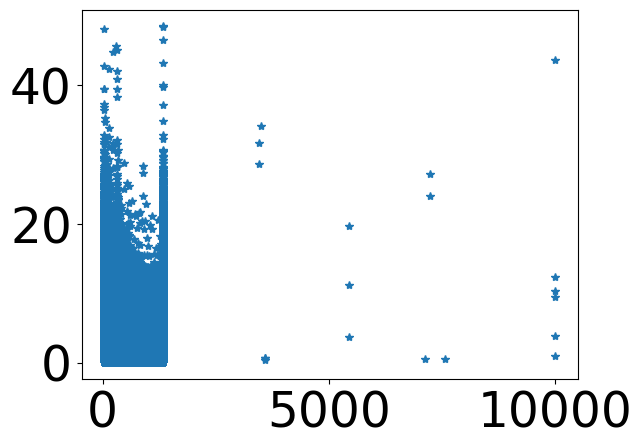

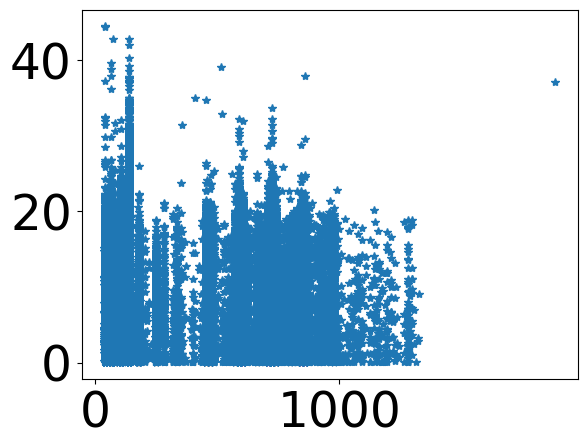

In [5]:
plt.figure()
plt.plot(dl_pkt_interval[:, 2], dl_pkt_interval[:, 0], '*')

plt.figure()
plt.plot(ul_pkt_interval[:, 2], ul_pkt_interval[:, 0], "*")

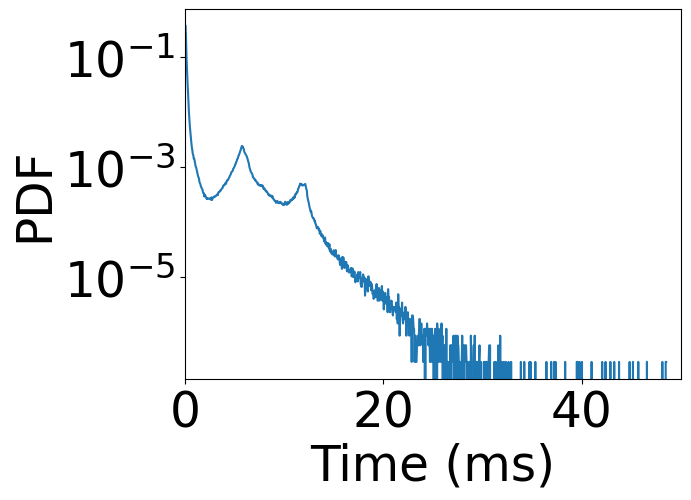

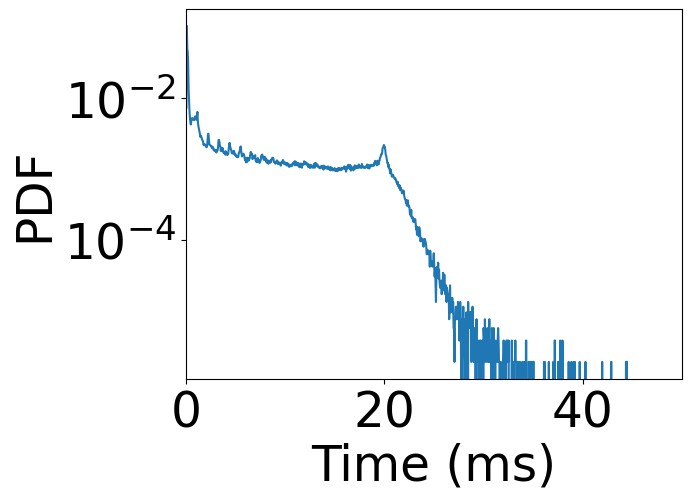

In [6]:
plt.figure()
plt.plot(dl_bins_count[1:], dl_pdf)
plt.xlim([0, 50])
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")
# plt.title("Downlink pkt inter-arrival time")

plt.figure()
plt.plot(ul_bins_count[1:], ul_pdf)
plt.xlim([0, 50])
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")
# plt.title("Uplink pkt inter-arrival time")

plt.show()

In [7]:
train = torch.tensor(dl_pkt_interval, dtype=torch.float)
pkt_interval, time, pkt_size = train[:, 0], train[:, 1], train[:, 2]

/home/wanhr/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/wanhr/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:905: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  r = torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


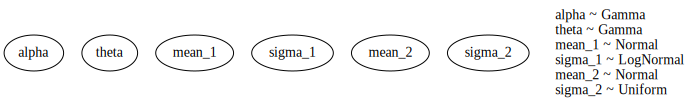

In [8]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

# def categorical_possion()

def model(pkt_size, pkt_interval=None):
    alpha = pyro.sample("alpha", dist.Gamma(1., 1.))
    theta = pyro.sample("theta", dist.Gamma(1., 1.))
    gamma = dist.Gamma(alpha, theta)

    mean_1 = pyro.sample("mean_1", dist.Normal(5, 2))
    sigma_1 = pyro.sample("sigma_1", dist.LogNormal(0., 0.05))
    gaussian_1 = dist.Normal(mean_1, sigma_1)

    mean_2 = pyro.sample("mean_2", dist.Normal(12, 2))
    sigma_2 = pyro.sample("sigma_2", dist.Uniform(0., 0.05))
    gaussian_2 = dist.Normal(mean_2, sigma_2)

    cat_dist = dist.OneHotCategorical(torch.Tensor([0.7, 0.2, 0.1]))
    y = cat_dist.sample()

    gamma_samp = gamma.sample()
    gaussian_samp_1 = gaussian_1.sample()
    gaussian_samp_2 = gaussian_2.sample()
    
    with pyro.plate("data", len(time)):
        return y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2

pyro.render_model(model, model_args=(pkt_size, pkt_interval), render_distributions=True)

In [9]:
def custom_guide(pkt_size, pkt_interval=None):
    alpha_alpha = pyro.param('alpha_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha_theta = pyro.param('alpha_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Gamma(alpha_alpha, alpha_theta))

    theta_alpha = pyro.param('theta_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta_theta = pyro.param('theta_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta = pyro.sample('theta', dist.Gamma(theta_alpha, theta_theta))

    mean_1_loc = pyro.param('mean_1_loc', lambda: torch.tensor(5. ))
    sigma_1_loc = pyro.param('sigma_1_loc', lambda: torch.tensor(0.))
    mean_1 = pyro.sample('mean_1', dist.Normal(mean_1_loc, torch.tensor(0.05)))
    sigma_1 = pyro.sample('sigma_1', dist.LogNormal(sigma_1_loc, torch.tensor(0.005)))

    mean_2_loc = pyro.param('mean_2_loc', lambda: torch.tensor(12. ))
    sigma_2_loc = pyro.param('sigma_2_loc', lambda: torch.tensor(0.))
    mean_2 = pyro.sample('mean_2', dist.Normal(mean_2_loc, torch.tensor(0.05)))
    sigma_2 = pyro.sample('sigma_2', dist.LogNormal(sigma_2_loc, torch.tensor(0.005)))

    # weight_1 = pyro.param('weight_1', lambda: torch.tensor(0.9),
    #                       constraint=constraints.positive)
    # weight_2 = pyro.param('weight_2', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # weight_3 = pyro.param('weight_3', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # cat = dist.OneHotCategorical(torch.Tensor([weight_1, weight_2, weight_3]))
    # y = pyro.sample('y', cat)

    return {'alpha': alpha, 'theta': theta, 'mean_1': mean_1, 'sigma_1': sigma_1, 
            'mean_2': mean_2, 'sigma_2': sigma_2}

/home/wanhr/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


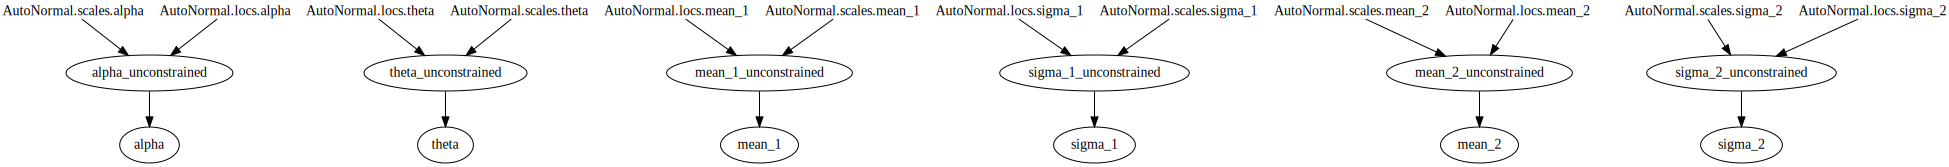

In [10]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

pyro.render_model(auto_guide, model_args=(pkt_size, pkt_interval), render_params=True)

In [11]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

map_model = pyro.infer

Step: 0, Elbo loss: 30.842268403619528
Step: 100, Elbo loss: 18.907759748399258
Step: 200, Elbo loss: 7.396948948502541
Step: 300, Elbo loss: 6.493626957759261
Step: 400, Elbo loss: 1.118507987819612
Step: 500, Elbo loss: 5.846849851310253
Step: 600, Elbo loss: 0.6129442602396011
Step: 700, Elbo loss: 1.7400896698236465
Step: 800, Elbo loss: 1.7945200577378273
Step: 900, Elbo loss: 0.13859781064093113
Step: 1000, Elbo loss: -0.23111329227685928
Step: 1100, Elbo loss: 0.3675026521086693
Step: 1200, Elbo loss: 0.9913820531219244
Step: 1300, Elbo loss: 0.8769375327974558
Step: 1400, Elbo loss: 0.18924257159233093
Step: 1500, Elbo loss: -0.09097516164183617
Step: 1600, Elbo loss: 1.1267105340957642
Step: 1700, Elbo loss: 1.0203499048948288
Step: 1800, Elbo loss: -0.19064028933644295
Step: 1900, Elbo loss: 0.4502040147781372
Step: 2000, Elbo loss: 0.42443534871563315
Step: 2100, Elbo loss: 2.611221395432949
Step: 2200, Elbo loss: 1.681947521865368
Step: 2300, Elbo loss: -0.625822888687253
S

Text(0, 0.5, 'ELBO loss')

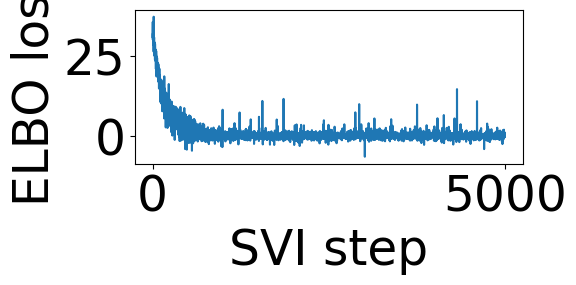

In [12]:
smoke_test = ('CI' in os.environ)

pyro.clear_param_store()

# These should be reset each training loop.
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(5000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(pkt_size, pkt_interval)
    losses.append(loss)
    if step % 100 == 0:
        print("Step: {}, Elbo loss: {}".format(step, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

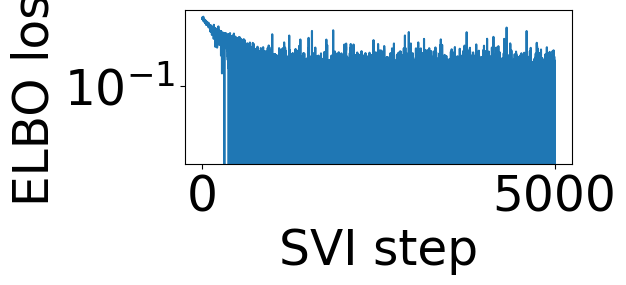

In [13]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [14]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.alpha -0.51090413
AutoNormal.scales.alpha 1.0577872
AutoNormal.locs.theta -0.6702001
AutoNormal.scales.theta 1.042702
AutoNormal.locs.mean_1 5.2484818
AutoNormal.scales.mean_1 1.776717
AutoNormal.locs.sigma_1 -0.011546962
AutoNormal.scales.sigma_1 0.041153196
AutoNormal.locs.mean_2 12.123497
AutoNormal.scales.mean_2 2.0656648
AutoNormal.locs.sigma_2 0.15774423
AutoNormal.scales.sigma_2 1.8407784


In [37]:
res_svi = []
for i in range(10000):
  predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=1)
  svi_samples = predictive(pkt_size, pkt_interval=None)

  gamma_samp = dist.Exponential(svi_samples['alpha'][0]).sample()
  gaussian_samp_1 = dist.Normal(svi_samples['mean_1'][0], svi_samples['sigma_1'][0]).sample()
  gaussian_samp_2 = dist.Normal(svi_samples['mean_2'][0], svi_samples['sigma_2'][0]).sample()
  cat_dist = dist.OneHotCategorical(torch.Tensor([0.9, 0.05, 0.05]))
  y = cat_dist.sample()
  res_svi.append(y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2)

print(res_svi)

[tensor(0.1053), tensor(4.5347), tensor(11.3400), tensor(23.8905), tensor(8.8596), tensor(0.0510), tensor(11.5820), tensor(1.3582), tensor(0.7891), tensor(2.2416), tensor(0.0516), tensor(4.5161), tensor(8.1620), tensor(11.5530), tensor(6.0048), tensor(0.1838), tensor(2.2513), tensor(0.7801), tensor(0.9513), tensor(0.1117), tensor(13.5968), tensor(0.4096), tensor(0.6331), tensor(0.6977), tensor(1.2779), tensor(4.9873), tensor(12.4020), tensor(0.2661), tensor(2.0204), tensor(0.4315), tensor(2.8424), tensor(0.4804), tensor(4.0198), tensor(0.3757), tensor(2.1121), tensor(0.0223), tensor(1.9163), tensor(0.3574), tensor(1.4338), tensor(0.0430), tensor(1.0572), tensor(13.3051), tensor(0.2203), tensor(0.0985), tensor(9.6220), tensor(2.3732), tensor(1.3112), tensor(0.5722), tensor(0.0496), tensor(1.9656), tensor(4.8574), tensor(0.4143), tensor(5.4011), tensor(11.9633), tensor(0.6903), tensor(1.6954), tensor(10.1247), tensor(8.5773), tensor(19.2464), tensor(8.1906), tensor(6.3502), tensor(2.1796

In [30]:
res_svi = np.array(res_svi)

res_count_svi, res_bins_count_svi = np.histogram(res_svi, bins=1000) 
res_pdf_svi = res_count_svi / sum(res_count_svi) 
res_cdf_svi = np.cumsum(res_pdf_svi) 


In [31]:
def guide_map(pkt_size, pkt_interval=None):
  alpha_alpha = pyro.param('alpha_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.unit_interval)
  alpha_theta = pyro.param('alpha_theta', lambda: torch.tensor(1.),
                            constraint=constraints.unit_interval)
  alpha = pyro.sample('alpha', dist.Gamma(alpha_alpha, alpha_theta))

  theta_alpha = pyro.param('theta_alpha', lambda: torch.tensor(1.),
                            constraint=constraints.unit_interval)
  theta_theta = pyro.param('theta_theta', lambda: torch.tensor(1.),
                            constraint=constraints.unit_interval)
  theta = pyro.sample('theta', dist.Gamma(theta_alpha, theta_theta))

  mean_1_loc = pyro.param('mean_1_loc', lambda: torch.tensor(5. ))
  sigma_1_loc = pyro.param('sigma_1_loc', lambda: torch.tensor(0.))
  mean_1 = pyro.sample('mean_1', dist.Normal(mean_1_loc, torch.tensor(0.05)))
  sigma_1 = pyro.sample('sigma_1', dist.Uniform(0, torch.tensor(0.005)))

  mean_2_loc = pyro.param('mean_2_loc', lambda: torch.tensor(12. ))
  sigma_2_loc = pyro.param('sigma_2_loc', lambda: torch.tensor(0.))
  mean_2 = pyro.sample('mean_2', dist.Normal(mean_2_loc, torch.tensor(0.05)))
  sigma_2 = pyro.sample('sigma_2', dist.Uniform(0, torch.tensor(0.005)))

  # weight_1 = pyro.param('weight_1', lambda: torch.tensor(0.9),
  #                       constraint=constraints.positive)
  # weight_2 = pyro.param('weight_2', lambda: torch.tensor(0.05),
  #                       constraint=constraints.positive)
  # weight_3 = pyro.param('weight_3', lambda: torch.tensor(0.05),
  #                       constraint=constraints.positive)
  # cat = dist.OneHotCategorical(torch.Tensor([weight_1, weight_2, weight_3]))
  # y = pyro.sample('y', cat)

  return {'alpha': alpha, 'theta': theta, 'mean_1': mean_1, 'sigma_1': sigma_1, 
          'mean_2': mean_2, 'sigma_2': sigma_2}

In [32]:
def train(model, guide, lr=0.02, n_steps=5000):
  pyro.clear_param_store()
  adam_params = {"lr": lr}
  adam = pyro.optim.Adam(adam_params)
  svi = pyro.infer.SVI(model, guide, adam, loss=pyro.infer.Trace_ELBO())

  for step in range(n_steps):
      loss = svi.step(data)
      if step % 50 == 0:
          print('[iter {}]  loss: {:.4f}'.format(step, loss))

Step: 0, Elbo loss: 7872.770866215229
Step: 100, Elbo loss: 8004.570480667055
Step: 200, Elbo loss: 13230.187210202217
Step: 300, Elbo loss: 6345.571331679821
Step: 400, Elbo loss: 6684.4162539839745
Step: 500, Elbo loss: 6067.378826856613
Step: 600, Elbo loss: 7004.39098328352
Step: 700, Elbo loss: 7486.258223205805
Step: 800, Elbo loss: 9646.688458502293
Step: 900, Elbo loss: 6349.065085172653
Step: 1000, Elbo loss: 10495.0597486943
Step: 1100, Elbo loss: 6749.578980594873
Step: 1200, Elbo loss: 6634.62934756279
Step: 1300, Elbo loss: 6732.0764793641865
Step: 1400, Elbo loss: 8738.731859505177
Step: 1500, Elbo loss: 5976.123085141182
Step: 1600, Elbo loss: 5771.308071762323
Step: 1700, Elbo loss: 6520.432249858975
Step: 1800, Elbo loss: 8012.364389419556
Step: 1900, Elbo loss: 13446.110454797745
Step: 2000, Elbo loss: 9246.677478685975
Step: 2100, Elbo loss: 5664.651266753674
Step: 2200, Elbo loss: 7847.549733266234
Step: 2300, Elbo loss: 6589.324202120304
Step: 2400, Elbo loss: 8131

Text(0, 0.5, 'ELBO loss')

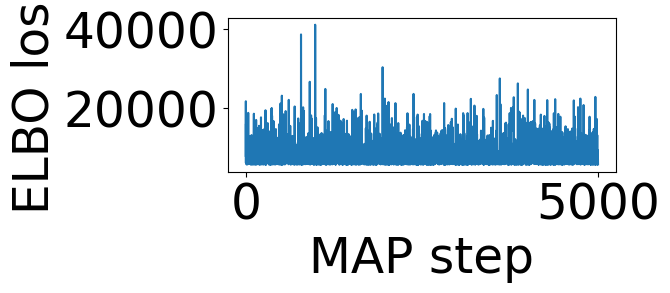

In [33]:
smoke_test = ('CI' in os.environ)

pyro.clear_param_store()

# These should be reset each training loop.
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide_map, adam, elbo)

losses = []
for step in range(5000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(pkt_size, pkt_interval)
    losses.append(loss)
    if step % 100 == 0:
        print("Step: {}, Elbo loss: {}".format(step, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("MAP step")
plt.ylabel("ELBO loss")

In [34]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

alpha_alpha 0.9999882
alpha_theta 0.9999999
theta_alpha 0.99999833
theta_theta 0.9999999
mean_1_loc 4.959938
sigma_1_loc 0.0
mean_2_loc 12.02768
sigma_2_loc 0.0


In [39]:
res = []
for i in range(10000):
  predictive = pyro.infer.Predictive(model, guide=guide_map, num_samples=1)
  svi_samples = predictive(pkt_size, pkt_interval=None)

  gamma_samp = dist.Exponential(svi_samples['alpha'][0]).sample()
  gaussian_samp_1 = dist.Normal(svi_samples['mean_1'][0], svi_samples['sigma_1'][0]).sample()
  gaussian_samp_2 = dist.Normal(svi_samples['mean_2'][0], svi_samples['sigma_2'][0]).sample()
  cat_dist = dist.OneHotCategorical(torch.Tensor([0.9, 0.05, 0.05]))
  y = cat_dist.sample()
  res.append(y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2)

print(res)

[tensor(2.2423), tensor(1.9096), tensor(0.4109), tensor(0.0431), tensor(0.1396), tensor(0.2437), tensor(1.0485), tensor(2.2004), tensor(0.5503), tensor(0.3270), tensor(240.3591), tensor(0.8243), tensor(0.3060), tensor(0.9571), tensor(11.9985), tensor(0.5551), tensor(2.6277), tensor(0.1585), tensor(2.8486), tensor(0.3963), tensor(0.0409), tensor(1.2695), tensor(2.8625), tensor(0.7887), tensor(4.2831), tensor(1.2745), tensor(0.7808), tensor(10.7861), tensor(1.0159), tensor(0.2439), tensor(0.1407), tensor(0.6334), tensor(0.7605), tensor(1.9549), tensor(4.1033), tensor(0.0461), tensor(0.7021), tensor(0.4192), tensor(1.0140), tensor(4.7244), tensor(4.5887), tensor(0.1482), tensor(1.5466), tensor(1.4118), tensor(1.1195), tensor(0.0015), tensor(2.9633), tensor(0.9448), tensor(42.4502), tensor(0.0927), tensor(1.2104), tensor(0.5048), tensor(0.4106), tensor(0.4415), tensor(0.0702), tensor(2.9545), tensor(0.2006), tensor(0.1471), tensor(3.2523), tensor(0.0038), tensor(22.3015), tensor(7.5130), t

/tmp/ipykernel_4164223/3529203262.py:16: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 500])
/tmp/ipykernel_4164223/3529203262.py:22: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 500])
/tmp/ipykernel_4164223/3529203262.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 500])


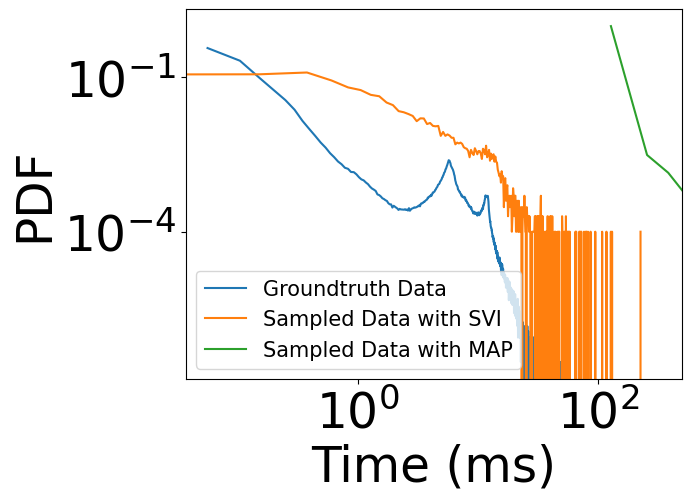

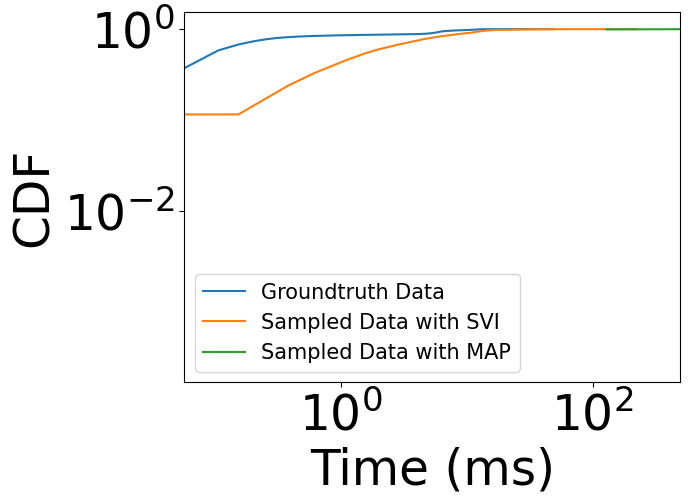

In [51]:
res = np.array(res)

res_count, res_bins_count = np.histogram(res, bins=1000) 
res_pdf = res_count / sum(res_count) 
res_cdf = np.cumsum(res_pdf) 

plt.figure(1)
plt.plot(dl_bins_count[1:], dl_pdf, label="Groundtruth Data")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")

# plt.figure()
plt.plot(res_bins_count_svi[1:], res_pdf_svi, label="Sampled Data with SVI")
plt.xlim([0, 500])
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")

plt.plot(res_bins_count[1:], res_pdf, label="Sampled Data with MAP")
plt.xlim([0, 500])
plt.yscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("PDF")
plt.legend(loc='lower left', prop={'size': 15})

# plt.yscale("log")

plt.figure(2)

plt.plot(dl_bins_count[1:], dl_cdf, label="Groundtruth Data")
plt.xlim([0, 500])
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Time (ms)")
plt.ylabel("CDF")

plt.plot(res_bins_count_svi[1:], res_cdf_svi, label="Sampled Data with SVI")
# plt.yscale("log")

plt.plot(res_bins_count[1:], res_cdf, label="Sampled Data with MAP")
plt.xlim([0, 500])
plt.legend(loc='lower left', prop={'size': 15})

plt.show()